In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
weather = pd.read_csv('weather.csv')
rides = pd.read_csv('cab_rides.csv')

In [3]:
rides.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [4]:
rides.dropna(axis = 0, inplace = True)

In [5]:
weather.isnull().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [6]:
weather.fillna(0, inplace = True)

In [7]:
weather_avg = weather.groupby('location').mean().reset_index()
weather_avg.drop(columns = 'time_stamp' , inplace = True)
weather_source = weather_avg.rename(columns =(lambda x :x + '_source'))       
weather_source.rename(columns= {'location_source' :'source'}, inplace = True)
weather_destination = weather_avg.rename(columns =(lambda x :x+'_destination'))       
weather_destination.rename(columns= {'location_destination' :'destination'} ,inplace = True)
data = rides\
       .merge(weather_source ,on ='source')\
       .merge(weather_destination ,on = 'destination')

#binary encoding to cab_type

data['cab_type'] =data['cab_type'].replace({'Uber':1,'Lyft':0})

def one_hot_encode(df , column , prefix):
    dummy = pd.get_dummies(df[column] ,prefix = prefix)
    df = pd.concat([df , dummy] ,axis =1)
    df =df.drop(column , axis =1)
    
    return df

data = one_hot_encode(data ,column =  'destination' , prefix = 'desti')
data = one_hot_encode(data ,column =  'source' , prefix = 'src')
data = one_hot_encode(data ,column =  'product_id' , prefix = 'pid')
data = one_hot_encode(data ,column =  'name' , prefix = 'nm')

In [8]:
train, test = train_test_split(data, test_size = 0.3)

In [9]:
import os  
os.makedirs('folder/subfolder', exist_ok = True)  
train.to_csv('folder/subfolder/train_final_project.csv') 
test.to_csv('folder/subfolder/test_final_project.csv') 

In [10]:
id_list_train = list(train['id'])
rides['bool'] = rides['id'].isin(id_list_train)
train_original = rides.loc[rides['bool'], :]

id_list_test = list(test['id'])
rides['bool'] = rides['id'].isin(id_list_test)
test_original = rides.loc[rides['bool'], :]

In [11]:
ols_object_basic = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_original)
model_basic = ols_object_basic.fit()
model_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 1.700e+05
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:25:49   Log-Likelihood:            -1.0421e+06
No. Observations:              446583   AIC:                         2.084e+06
Df Residuals:                  446548   BIC:                         2.085e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -0.0022   3.05e-05    -71.058      0.000      -0.002      -0.002
cab_type[T.Uber]                                      -0.7290      0.005   -147.990      0.000      -0.739      -0.719
destination[T.Beacon Hill]                            -0.3036      0.018    -16.570      0.000      -0.340      -0.268
destination[T.Boston University]                      -0.0745      0.015     -4.854      0.000      -0.105      -0.044
destination[T.Fenway]                                 -0.3874      0.015    -25.495      0.000      -0.417      -0.358
destination[T.Financial District]                      0.4073      0.018     22.230      0.000       0.371       0.443
destination[T.Haymarket Square]                        0.1451      0.015      9.403      0.000       0.115       0.175
destination[T.North End]                              -0.0028      0.015     -0.185      0.853      -0.032       0.027
destination[T.North Station]                           0.2080      0.018     11.335      0.000       0.172       0.244
destination[T.Northeastern University]                -0.0580      0.015     -3.854      0.000      -0.087      -0.028
destination[T.South Station]                          -0.0951      0.015     -6.254      0.000      -0.125      -0.065
destination[T.Theatre District]                        0.2537      0.018     13.866      0.000       0.218       0.290
destination[T.West End]                               -0.0306      0.018     -1.675      0.094      -0.067       0.005
source[T.Beacon Hill]                                 -0.3237      0.018    -17.647      0.000      -0.360      -0.288
source[T.Boston University]                           -0.2705      0.015    -17.528      0.000      -0.301      -0.240
source[T.Fenway]                                      -0.0802      0.015     -5.263      0.000      -0.110      -0.050
source[T.Financial District]                           0.3259      0.018     17.627      0.000       0.290       0.362
source[T.Haymarket Square]                             0.3800      0.016     24.358      0.000       0.349       0.411
source[T.North End]                                    0.5561      0.015     36.952      0.000       0.527       0.586
source[T.North Station]                                0.0667      0.018      3.624      0.000       0.031       0.103
source[T.Northeastern University]                     -0.2903      0.015    -19.128      0.000      -0.320      -0.261
source[T.South Station]                                0.1851      0.015     12.327      0.000       0.156       0.215
source[T.Theatre District]                             0.5179      0.018     28.293      0.000       0.482  

In [12]:
np.sqrt(((test_original.price - model_basic.predict(test_original))**2).mean())

2.481570853314816

In [13]:
np.sqrt(model_basic.mse_resid)

2.4959450229016955

In [31]:
out = model_basic.outlier_test()

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

sns.scatterplot(ax = axes[0], x = (model_basic.fittedvalues), y = (model_basic.resid),color = 'orange')
sns.lineplot(ax = axes[0], x = [model_basic.fittedvalues.min(), model_basic.fittedvalues.max()], y = [0,0], color = 'blue')
axes[0].set_xlabel('Fitted values') 
axes[0].set_ylabel('Residuals')

sns.scatterplot(ax = axes[1], x = (model_basic.fittedvalues), y = (out.student_resid),color = 'orange')
sns.lineplot(ax = axes[1], x = [model_basic.fittedvalues.min(), model_basic.fittedvalues.max()], y = [0,0], color = 'blue')
axes[1].set_xlabel('Fitted values')
axes[1].set_ylabel('Studentized Residuals')

In [27]:
import statsmodels.api as sm

In [24]:
#take a look at high leverage points
influence = model_basic.get_influence()
leverage = influence.hat_matrix_diag

In [30]:
#calculate number of high leverage points
average_leverage = (model_basic.df_model+1)/model_basic.nobs

high_leverage_threshold = 4*average_leverage

np.sum(leverage>high_leverage_threshold)

1192

In [36]:
#remove high leverage
train_original_filtered = train_original.drop(np.where(leverage>high_leverage_threshold)[0])
#np.intersect1d(np.where(np.abs(out.student_resid)>3)[0]

KeyError: '[7674, 9331, 9333, 9334, 12755, 12757, 14136, 14335, 15109, 15111, 18159, 18700, 19197, 22360, 23479, 23482, 24813, 24816, 25642, 27921, 28028, 28029, 34544, 34547, 36441, 39810, 39811, 39812, 41182, 41186, 41862, 42855, 43071, 43650, 44207, 44954, 45336, 46041, 46042, 47544, 48518, 50059, 50063, 51892, 51894, 52606, 54395, 56989, 56991, 57978, 57979, 64330, 64337, 64498, 64500, 65925, 66612, 69678, 70442, 72133, 73954, 73955, 79034, 80213, 80491, 82340, 85835, 85836, 90903, 91510, 92599, 92602, 95090, 97089, 98765, 98768, 99119, 99734, 100340, 101638, 101779, 101781, 103642, 103643, 104364, 104365, 104460, 104464, 111409, 111569, 113021, 113022, 113106, 117773, 117777, 117778, 119405, 119407, 120102, 120105, 121942, 121944, 123757, 124704, 124840, 124841, 125263, 125559, 125560, 127510, 128947, 130274, 130277, 132841, 132842, 132843, 135072, 135073, 135514, 135516, 136145, 137087, 138989, 138990, 138991, 138992, 139425, 139428, 139839, 141307, 141952, 141953, 142069, 143441, 143443, 145010, 145011, 145012, 146862, 147792, 147794, 147795, 150686, 150687, 152505, 152506, 155225, 155228, 157778, 157779, 158874, 160561, 161900, 161995, 168937, 168939, 169648, 169651, 170440, 171833, 172932, 172933, 173909, 173910, 174471, 174474, 174475, 175025, 177372, 177373, 180696, 180698, 180699, 181183, 181184, 181359, 182099, 183007, 183008, 183009, 183318, 184305, 186667, 187293, 191681, 191682, 191724, 191725, 192999, 193923, 193924, 196303, 197024, 197027, 199023, 199508, 199509, 202482, 202485, 203879, 204631, 204633, 204967, 206946, 207447, 212344, 212345, 215961, 215963, 215964, 219666, 219667, 219712, 219714, 219715, 219745, 219854, 219855, 220164, 221491, 221495, 224473, 224474, 225229, 225232, 227580, 227581, 227652, 229250, 230371, 231708, 236193, 240761, 240765, 241026, 242493, 243006, 243176, 246688, 247979, 248116, 249549, 249550, 249551, 249826, 250054, 251973, 252167, 252474, 253098, 258127, 258506, 258726, 259180, 259552, 259553, 259636, 261136, 262780, 263198, 265970, 268481, 270716, 271055, 271058, 272140, 272747, 273806, 273807, 276936, 277586, 278137, 278821, 278822, 278823, 282241, 282242, 282243, 282611, 284804, 285361, 287450, 287452, 289901, 289903, 291816, 296038, 296039, 296040, 301572, 301575, 301984, 302073, 304082, 306556, 306557, 308039, 308040, 308323, 310817, 310818, 311099, 312541, 312542, 312919, 312933, 318578, 319918, 322022, 322023, 322444, 326473, 327695, 329806, 329810, 331378, 331380, 331902, 332455, 332886, 332887, 335172, 336272, 338362, 338604, 339212, 339214, 341119, 343314, 343315, 344849, 346147, 346476, 347901, 348349, 349219, 349222, 350321, 350322, 350323, 352660, 353078, 353379, 353436, 353439, 354284, 357121, 360520, 360535, 360800, 360801, 361016, 361017, 361283, 361285, 361286, 362093, 362663, 366460, 366461, 368411, 368413, 369015, 369016, 370127, 370130, 371765, 371768, 373403, 373407, 373593, 374392, 375165, 376155, 377053, 377056, 379427, 382513, 382682, 382684, 384780, 384781, 385239, 388248, 389210, 389591, 394410, 395109, 395110, 395210, 395211, 395212, 395772, 397441, 397442, 397443, 401268, 401269, 401963, 405024, 406400, 409216, 411044, 411410, 411804, 412022, 418037, 418495, 418496, 418861, 421127, 421129, 421130, 421763, 421764, 421776, 421779, 421780, 422867, 424241, 424244, 428569, 429372, 429373, 429660, 430639, 430640, 431682, 436887, 437033, 437035, 438906, 440963, 440965, 445053, 445054, 446056] not found in axis'

In [14]:
ols_object_distance = smf.ols(formula = 'price~distance', data = train_original)
model_distance = ols_object_distance.fit()
model_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                 6.014e+04
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:25:50   Log-Likelihood:            -1.6023e+06
No. Observations:              446583   AIC:                         3.205e+06
Df Residuals:                  446581   BIC:                         3.205e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3590      0.028    364.357      0.000      10.303      10.415
distance       2.8261      0.012    245.233      0.000       2.803       2.849
==============================================================================
Omnibus:                    47844.473   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66565.123
Skew:                           0.855   Prob(JB):                         0.00
Kurtosis:                       3.808   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
np.sqrt(((test_original.price - model_distance.predict(test_original))**2).mean())

8.755983735084488

In [16]:
np.sqrt(model_distance.mse_resid)

8.74982048160825

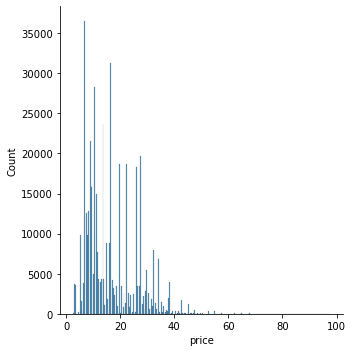

In [17]:
sns.displot(data = train, x = 'price', kind = 'hist')

In [18]:
new_train = train.copy()
new_train = new_train.drop(['price', 'id'], axis = 1)
new_train['log_distance'] = new_train['distance'].apply(lambda x: np.log(x))

In [19]:
new_test = test.copy()
new_test = new_test.drop(['price', 'id'], axis = 1)
new_test['log_distance'] = new_test['distance'].apply(lambda x: np.log(x))

/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


2.128878538946581

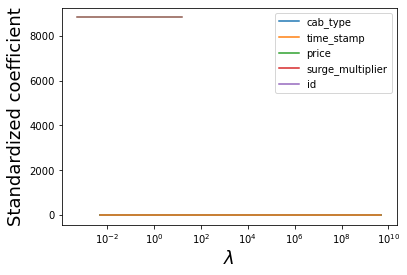

In [20]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

#Taking the log transform of house_price as house prices have a right-skewed distribution
y = np.log(train.price)

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = new_train; 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Test dataset
Xtest = new_test

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e+02, tolerance: 1.442e+01
  model = cd_fast.enet_coordinate_descent(


2.128673366471029

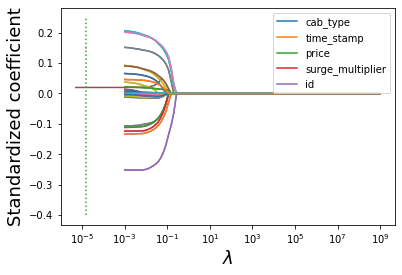

In [21]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())